In [1]:
import os, time
from pathlib import Path

# Possible locations (Colab typical)
possible_csv_dirs = [Path("/content/csv_files"), Path("/mnt/data/csv_files"), Path("./csv_files")]
csv_dir = None
for p in possible_csv_dirs:
    if p.exists() and p.is_dir():
        csv_dir = p
        break

# If not found, create /content/csv_files
if csv_dir is None:
    csv_dir = Path("/content/csv_files")
    csv_dir.mkdir(parents=True, exist_ok=True)

# outputs folder
out_dir = Path("/content/outputs")
out_dir.mkdir(parents=True, exist_ok=True)

print("Using csv_files at:", csv_dir)
print("Using outputs at:", out_dir)


Using csv_files at: /content/csv_files
Using outputs at: /content/outputs


In [2]:

# Read input CSVs
import pandas as pd
from pathlib import Path

csv_dir = Path("/content/csv_files")
hist_path = csv_dir / "historical_data.csv"
fg_path = csv_dir / "fear_greed_index.csv"

if not hist_path.exists() or not fg_path.exists():
    print("One or both input files not found in /content/csv_files. Please upload them to that folder first.")
else:
    hist = pd.read_csv(hist_path)
    fg = pd.read_csv(fg_path)
    print("Loaded historical:", hist.shape)
    print("Loaded fear/greed:", fg.shape)
    display(hist.head())
    display(fg.head())


Loaded historical: (211224, 16)
Loaded fear/greed: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:

# Preprocessing & aggregation
import numpy as np
import pandas as pd

# Ensure hist and fg are loaded (in case user reruns this cell)
try:
    hist
except NameError:
    raise RuntimeError("Please run the previous cell to load the CSV files into the runtime.")

# Detect time column
time_col = None
for c in hist.columns:
    if c.lower() in ("time","timestamp","date","datetime"):
        time_col = c
        break

if time_col:
    hist[time_col] = pd.to_datetime(hist[time_col], errors="coerce")
    hist["trade_date"] = hist[time_col].dt.date
else:
    # heuristic fallback
    for c in hist.columns:
        if any(k in c.lower() for k in ("date","dt","time")):
            time_col = c
            hist[time_col] = pd.to_datetime(hist[time_col], errors="coerce")
            hist["trade_date"] = hist[time_col].dt.date
            break
    else:
        hist["trade_date"] = pd.NaT
        print("Warning: Could not detect a datetime column. trade_date will be NaT.")

# Detect PnL column
pnl_col = None
for c in hist.columns:
    key = c.lower().replace(" ", "")
    if "closedpnl" in key or key in ("pnl","pl","profit","profitloss"):
        pnl_col = c
        break
if pnl_col is None:
    # create placeholder zero column
    hist["closedPnL"] = 0.0
    pnl_col = "closedPnL"
else:
    hist[pnl_col] = pd.to_numeric(hist[pnl_col], errors="coerce")

# Derived fields
if "size" in hist.columns:
    hist["abs_size"] = pd.to_numeric(hist["size"], errors="coerce").abs()
else:
    hist["abs_size"] = np.nan

if "leverage" in hist.columns:
    hist["leverage"] = pd.to_numeric(hist["leverage"], errors="coerce")

hist["is_win"] = hist[pnl_col] > 0

# Aggregation
daily = hist.groupby("trade_date").agg(
    pnl_sum = (pnl_col, "sum"),
    pnl_mean = (pnl_col, "mean"),
    volume_sum = ("abs_size", "sum"),
    win_rate = ("is_win", "mean"),
    avg_leverage = ("leverage", "mean") if "leverage" in hist.columns else ("abs_size","mean")
).reset_index()

display(daily.head())


,trade_date,pnl_sum,pnl_mean,volume_sum,win_rate,avg_leverage
0,1970-01-01,1.029696e+07,48.749001,0.0,0.411265,NaN


In [4]:

# Prepare and merge Fear & Greed
fg_date_col = None
for c in fg.columns:
    if c.lower() in ("date","day","dt"):
        fg_date_col = c
        break
if fg_date_col is None:
    fg_date_col = fg.columns[0]

fg[fg_date_col] = pd.to_datetime(fg[fg_date_col], errors="coerce").dt.date

# detect classification column
cls_col = None
for c in fg.columns:
    if "class" in c.lower() or "fear" in c.lower() or "greed" in c.lower():
        cls_col = c
        break
if cls_col is None and fg.shape[1] >= 2:
    cls_col = fg.columns[1]

fg = fg[[fg_date_col, cls_col]].rename(columns={fg_date_col:"trade_date", cls_col:"classification"})

merged = pd.merge(daily, fg, on="trade_date", how="left")
display(merged.head())


,trade_date,pnl_sum,pnl_mean,volume_sum,win_rate,avg_leverage,classification
0,1970-01-01,1.029696e+07,48.749001,0.0,0.411265,NaN,NaN


In [5]:

# Save generated CSVs into csv_files/ but never overwrite existing input files.
from pathlib import Path
from datetime import datetime

csv_dir = Path("/content/csv_files")
def safe_save_csv(df, desired_name):
    dest = csv_dir / desired_name
    if dest.exists():
        # do not overwrite input; append timestamp
        ts = datetime.utcnow().strftime("%Y%m%dT%H%M%S")
        dest = csv_dir / (Path(desired_name).stem + f"_generated_{ts}" + Path(desired_name).suffix)
    df.to_csv(dest, index=False)
    print("Saved:", dest)
    return dest

p1 = safe_save_csv(daily, "daily_aggregates.csv")
p2 = safe_save_csv(merged, "merged_with_fear_greed.csv")


Saved: /content/csv_files/daily_aggregates.csv
Saved: /content/csv_files/merged_with_fear_greed.csv


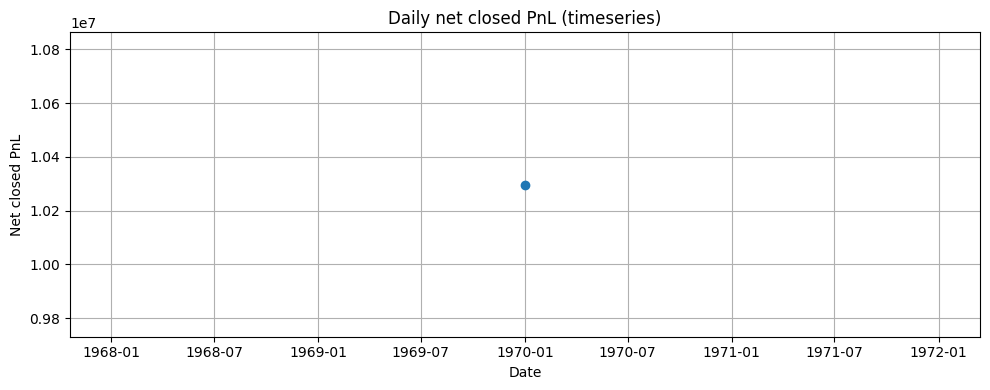

Saved: /content/outputs/daily_pnl_timeseries.png


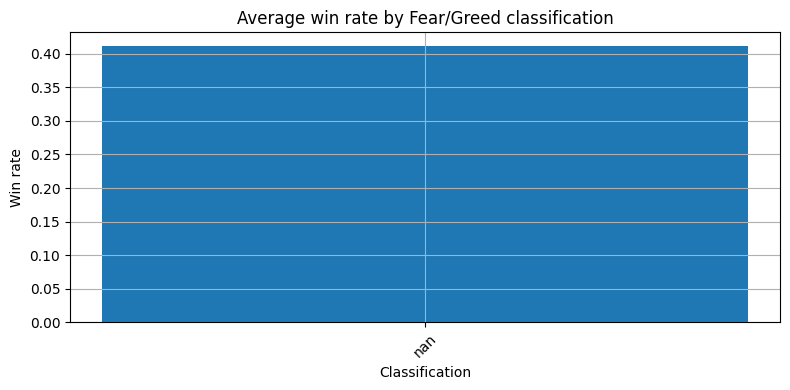

Saved: /content/outputs/winrate_by_classification.png
0   NaN
Name: classification, dtype: float64


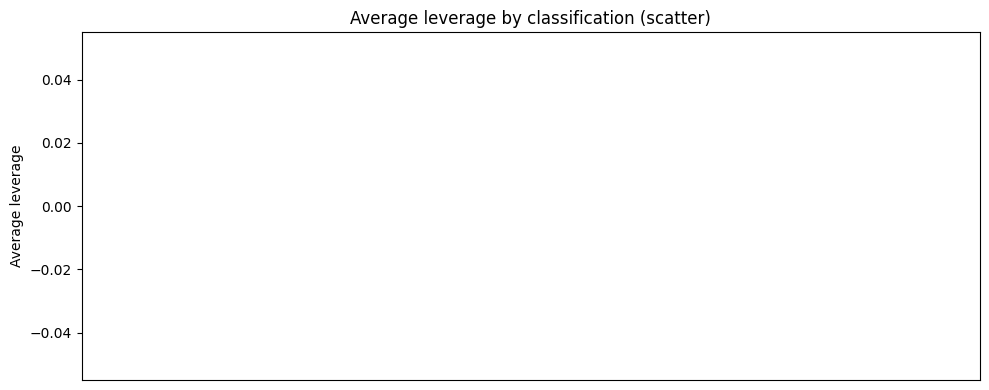

Saved: /content/outputs/leverage_by_classification.png


In [9]:
# Plots: save images into outputs/ and display inline
import matplotlib.pyplot as plt
from pathlib import Path
out_dir = Path("/content/outputs")
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Daily PnL timeseries
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(merged["trade_date"]), merged["pnl_sum"], marker='o')
plt.title("Daily net closed PnL (timeseries)")
plt.xlabel("Date")
plt.ylabel("Net closed PnL")
plt.grid(True)
png1 = out_dir / "daily_pnl_timeseries.png"
plt.tight_layout()
plt.savefig(png1)
plt.show()
print("Saved:", png1)

# 2) Win rate by classification
win_by_class = merged.groupby("classification", dropna=False)["win_rate"].mean().reset_index()
plt.figure(figsize=(8,4))
plt.bar(win_by_class["classification"].astype(str), win_by_class["win_rate"])
plt.title("Average win rate by Fear/Greed classification")
plt.xlabel("Classification")
plt.ylabel("Win rate")
plt.xticks(rotation=45)
plt.grid(True)
png2 = out_dir / "winrate_by_classification.png"
plt.tight_layout()
plt.savefig(png2)
plt.show()
print("Saved:", png2)

# 3) Leverage by classification (if present)
if "avg_leverage" in merged.columns:
    plt.figure(figsize=(10,4))
    cats = merged["classification"].astype(str)
    cat_order = sorted(merged["classification"].dropna().unique(), key=lambda x: str(x))
    cat_map = {k:i for i,k in enumerate(cat_order)}
    x_vals = merged["classification"].map(cat_map)
    print(x_vals)
    plt.scatter(x_vals, merged["avg_leverage"], alpha=0.7)
    plt.xticks(list(cat_map.values()), list(cat_map.keys()), rotation=45)
    plt.title("Average leverage by classification (scatter)")
    plt.ylabel("Average leverage")
    png3 = out_dir / "leverage_by_classification.png"
    plt.tight_layout()
    plt.savefig(png3)
    plt.show()
    print("Saved:", png3)
else:
    print("avg_leverage not present; skipping leverage plot.")
